### PCA and Logistic Regression Classifier

In [3]:
from Tumor_Classifier_Utils import *

In [4]:
data_train = scio.loadmat('Data/tumor_train_data_32.mat')
data_val = scio.loadmat('Data/tumor_val_data_32.mat')
data_test = scio.loadmat('Data/tumor_test_data_32.mat')

N = 32 # image size (64x64 after preprocessing)
num_classes = 4; # how many different types of classifications we have 

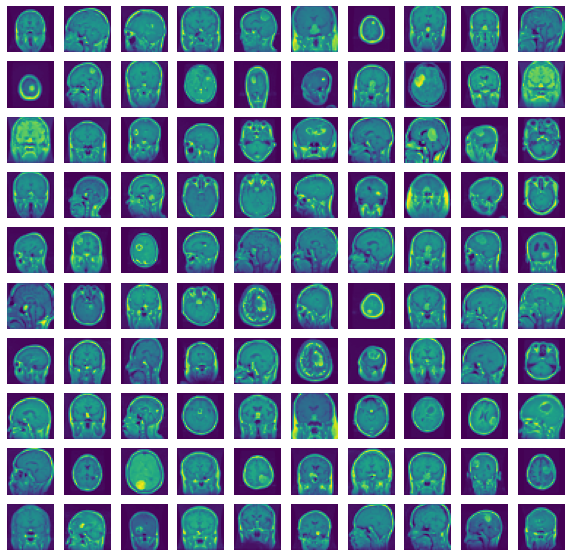

In [5]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(data_train['img_train'][:,:,i])
    ax.axis('off')

In [5]:
train = np.transpose(data_train['img_train'], (2, 0, 1)).reshape(-1, N, N, 1)
train_y = data_train['labels_train']
val = np.transpose(data_val['img_val'], (2, 0, 1)).reshape(-1, N, N, 1)
val_y = data_val['labels_val']
test = np.transpose(data_test['img_test'], (2, 0, 1)).reshape(-1, N, N, 1)
test_y = data_test['labels_test']

print(train.shape)
print(val.shape)
print(test.shape)

(2500, 32, 32, 1)
(500, 32, 32, 1)
(264, 32, 32, 1)


## Formatting for PCA

In [6]:
train_PCA = np.reshape(train[:,:,:,:], (2500, -1))
val_PCA = np.reshape(val[:,:,:,:], (500, -1))
test_PCA = np.reshape(test[:,:,:,:], (264, -1))

print(train_PCA.shape)
print(val_PCA.shape)
print(test_PCA.shape)

(2500, 1024)
(500, 1024)
(264, 1024)


## PCA

In [7]:
pca = decomposition.PCA()
pca.fit(train_PCA)

PCA()

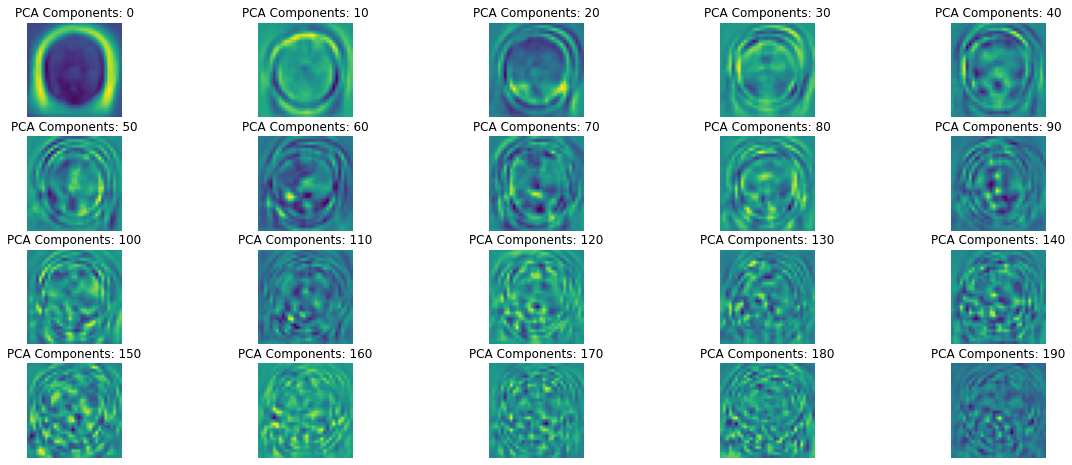

In [28]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1)
    pc = np.reshape(pca.components_[i*10,:], (N, N)) 
    ax.imshow(pc)
    ax.set_title("PCA Components: " + str(i*10))
    plt.axis('off')

In [17]:
transformed_train = pca.transform(train_PCA)
transformed_val = pca.transform(val_PCA)
transformed_test = pca.transform(test_PCA)

In [42]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
top90 = np.where(cumulative_sum > 0.90)[0][0]
top95 = np.where(cumulative_sum > 0.95)[0][0]
top99 = np.where(cumulative_sum > 0.99)[0][0]

top90: 138, top95: 228, top99: 462


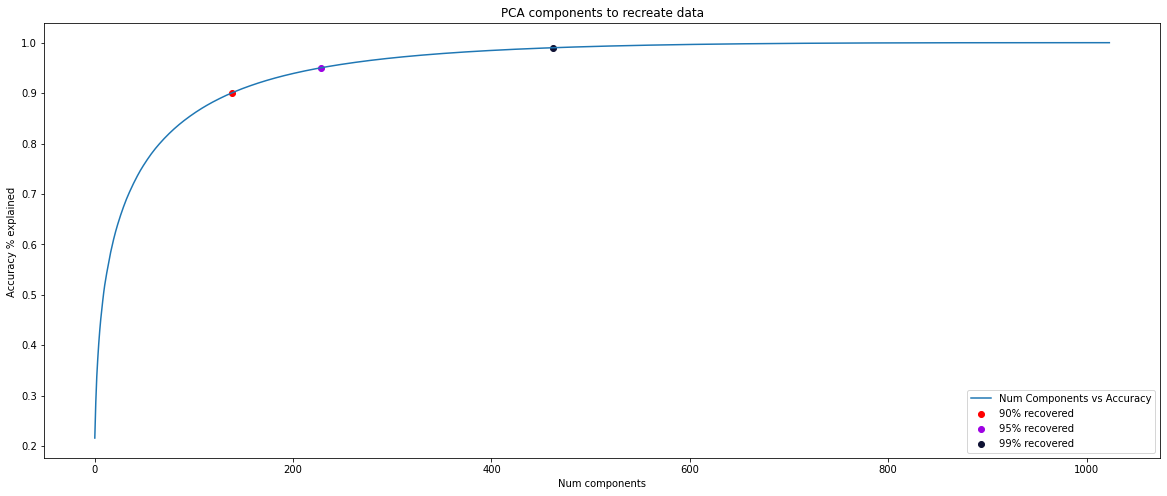

In [43]:
plot_cumulative_sum(cumulative_sum, top90, top95, top99)

(2500, 1024)
(2500, 1024)


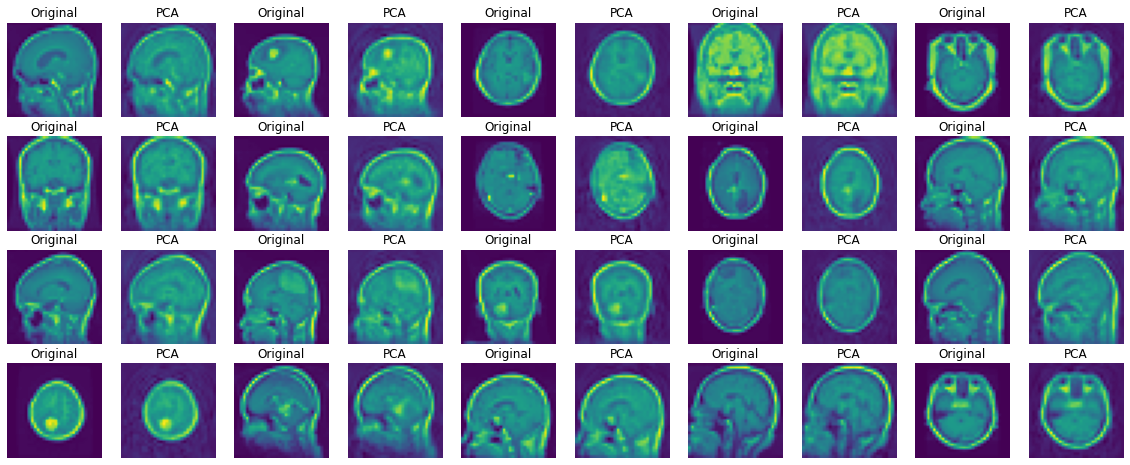

In [46]:
transformed_train_95 = transformed_train
transformed_train_95[:,top95+1:] = 0
print(transformed_train_95.shape)

transform_top95_generate = pca.inverse_transform(transformed_train_95)
print(transform_top95_generate.shape)

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, 2*i + 1)
    ax.imshow(np.reshape(train_PCA[i,:], (N,N)))
    ax.set_title('Original')
    ax.axis('off')
    ax = fig.add_subplot(4, 10, 2*i + 2)
    pc = np.reshape(transform_top95_generate[i,:], (N, N)) 
    ax.imshow(pc)
    ax.set_title('PCA')
    ax.axis('off')

In [47]:
# choose to use 95% recreation
transformed_train_95 = transformed_train[:, 0:top95]
transformed_val_95 = transformed_val[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

print(transformed_train_95.shape)
print(train_y.shape)

(2500, 228)
(2500, 1)


## Logistic Regression

In [48]:
param_grid = {'penalty': ["l2"], 'C': list(range(1, 30)), 'fit_intercept': [True, False], 'class_weight': ["balanced"], 'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}

# Find Optimal Hyperparameters and then create model
model = LogisticRegression()
best_params = search_hyperparams(model, param_grid, transformed_train_95, train_y, transformed_val_95, val_y)

c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:

{'C': 2, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy 0.664
{'C': 17, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Accuracy 0.59


c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [49]:
model_opt = model.set_params(**best_params)
model_opt.fit(transformed_train_95, train_y)

c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=2, class_weight='balanced', fit_intercept=False,
                   solver='liblinear')

In [50]:
model.fit(transformed_train_95, train_y)

c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=2, class_weight='balanced', fit_intercept=False,
                   solver='liblinear')

              precision    recall  f1-score   support

           0       0.07      0.02      0.03        50
           1       0.69      0.74      0.71        76
           2       0.74      0.69      0.71        87
           3       0.43      0.75      0.55        51

    accuracy                           0.59       264
   macro avg       0.48      0.55      0.50       264
weighted avg       0.54      0.59      0.55       264



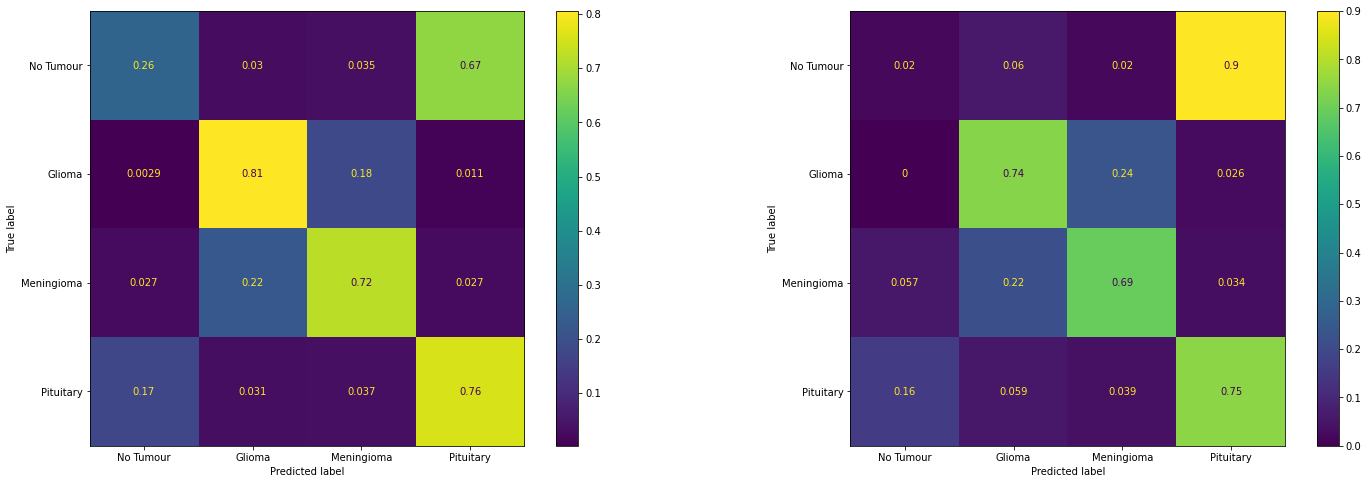

In [53]:
def eval_model_pca(model, X_train, Y_train, X_test, Y_test):
    labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax, display_labels=labels)
    #conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax, display_labels=labels)
    #conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))
    
eval_model_pca(model, transformed_train_95, train_y, transformed_test_95, test_y)

## LDA

In [8]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(np.array(train_PCA), np.array(train_y))
transformed_train_LDA = lda.transform(train_PCA)
transformed_val_LDA = lda.transform(val_PCA)
transformed_test_LDA = lda.transform(test_PCA)

c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
print(np.shape(transformed_train_LDA))

(2500, 3)


## LDA vs PCA

Text(0.5, 1.0, 'First Three PCA Components')

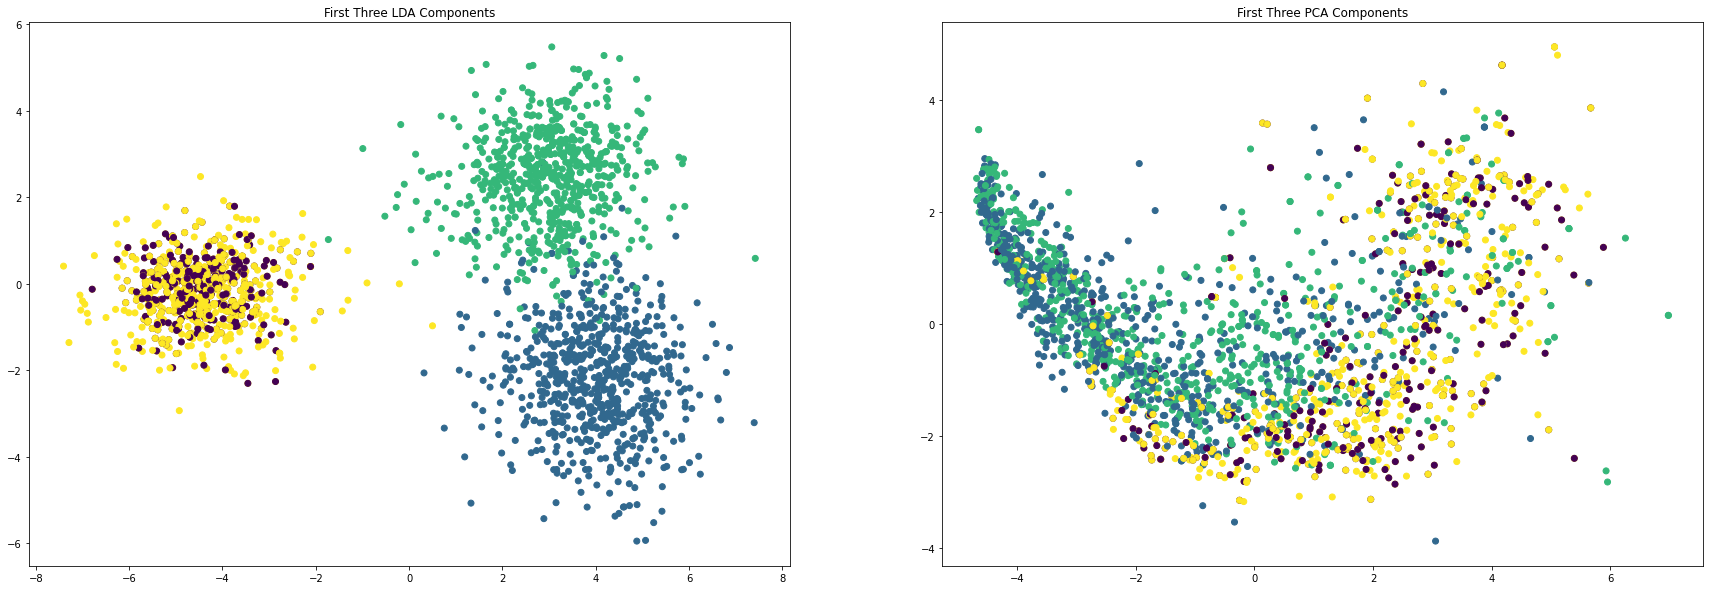

In [18]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(30)
ax = fig.add_subplot(1, 2, 1)
ax.scatter(transformed_train_LDA[:,0], transformed_train_LDA[:,1], c=train_y);
ax.set_title('First Three LDA Components')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(transformed_train[:,0], transformed_train[:,1], c=train_y);
ax.set_title('First Three PCA Components')

## Logistic Regression LDA

c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: D

{'C': 1, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Validation Accuracy 0.662
{'C': 2, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy 0.634
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.84      0.76      0.80        76
           2       0.78      0.84      0.81        87
           3       0.33      0.53      0.41        51

    accuracy                           0.60       264
   macro avg       0.49      0.53      0.51       264
weighted avg       0.57      0.60      0.58       264



c:\Users\Nicholas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


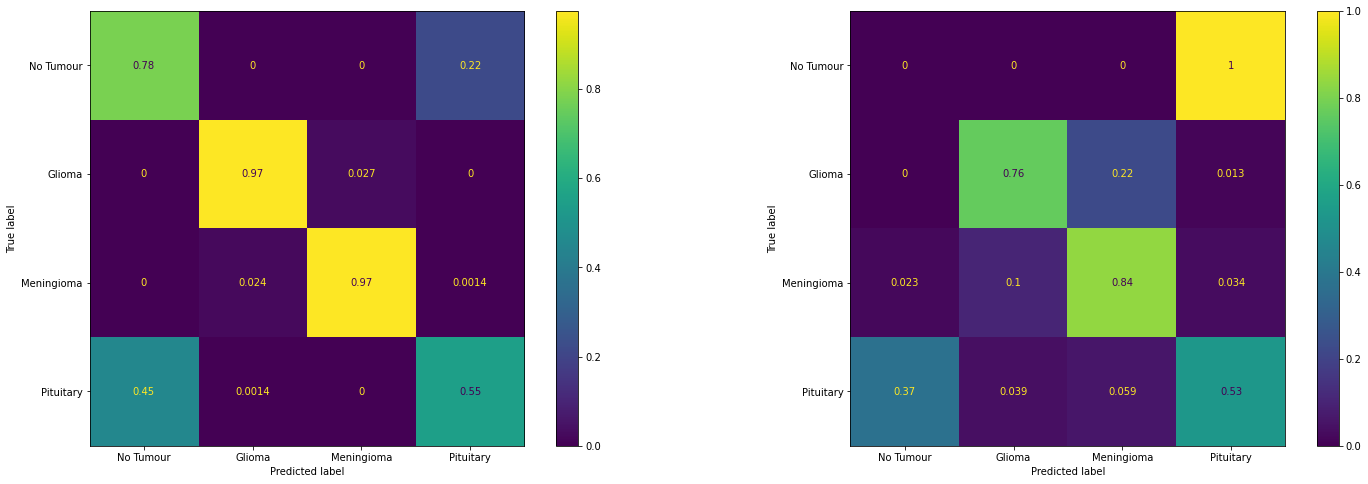

In [19]:
param_grid = {'penalty': ["l2"], 'C': list(range(1, 30)), 'fit_intercept': [True, False], 'class_weight': ["balanced"], 'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}

# Find Optimal Hyperparameters and then create model
model = LogisticRegression()
best_params = search_hyperparams(model, param_grid, transformed_train_LDA, train_y, transformed_val_LDA, val_y)

model_opt = model.set_params(**best_params)
model_opt.fit(transformed_train_LDA, train_y)

model.fit(transformed_train_LDA, train_y)

eval_model_pca(model, transformed_train_LDA, train_y, transformed_test_LDA, test_y)